In [5]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [23]:
import torch

print("Is CUDA available?", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


Is CUDA available? True
Current device: 0
Device name: Tesla T4


In [24]:
dataset_dir ='/kaggle/input/pcb-defects/PCB_DATASET'

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

In [26]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [27]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [28]:
def parse_xml(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  data = []

  file_name = root.find('filename').text
  width = int(root.find('size/width').text)
  height = int(root.find('size/height').text)

  for obj in root.findall('object'):
    name = obj.find('name').text
    xmin = int(obj.find('bndbox/xmin').text)
    ymin = int(obj.find('bndbox/ymin').text)
    xmax = int(obj.find('bndbox/xmax').text)
    ymax = int(obj.find('bndbox/ymax').text)

    data.append({
        'file_name': file_name,
        'width': width,
        'height': height,
        'name': name,
        'xmin': xmin,
        'ymin': ymin,
        'xmax': xmax,
        'ymax': ymax
    })
  return data

In [29]:
all_data = []

for root, dirs, files in os.walk(annot_dir):
  for name in files:
    if name.endswith('.xml'):
      xml_path = os.path.join(root, name)
      all_data.extend(parse_xml(xml_path))

In [30]:
data_frame = pd.DataFrame(all_data)
data_frame.head()

,file_name,width,height,name,xmin,ymin,xmax,ymax
0,01_mouse_bite_11.jpg,3034,1586,mouse_bite,1199,966,1234,1004
1,01_mouse_bite_11.jpg,3034,1586,mouse_bite,2042,755,2073,786
2,01_mouse_bite_11.jpg,3034,1586,mouse_bite,1472,607,1507,639
3,01_mouse_bite_17.jpg,3034,1586,mouse_bite,2168,854,2200,887
4,01_mouse_bite_17.jpg,3034,1586,mouse_bite,1513,919,1545,957


# Visualize dataset images with annotate bounding Boxes

In [31]:
def get_folder(image_name):
  if 'missing' in image_name.split('_'):
    return 'Missing_hole'
  elif 'mouse' in image_name.split('_'):
    return 'Mouse_bite'
  elif 'open' in image_name.split('_'):
    return 'Open_circuit'
  elif 'short' in image_name.split('_'):
    return 'Short'
  elif 'spur' in image_name.split('_'):
    return 'Spur'
  elif 'copper' in image_name.split('_'):
    return 'Spurious_copper'

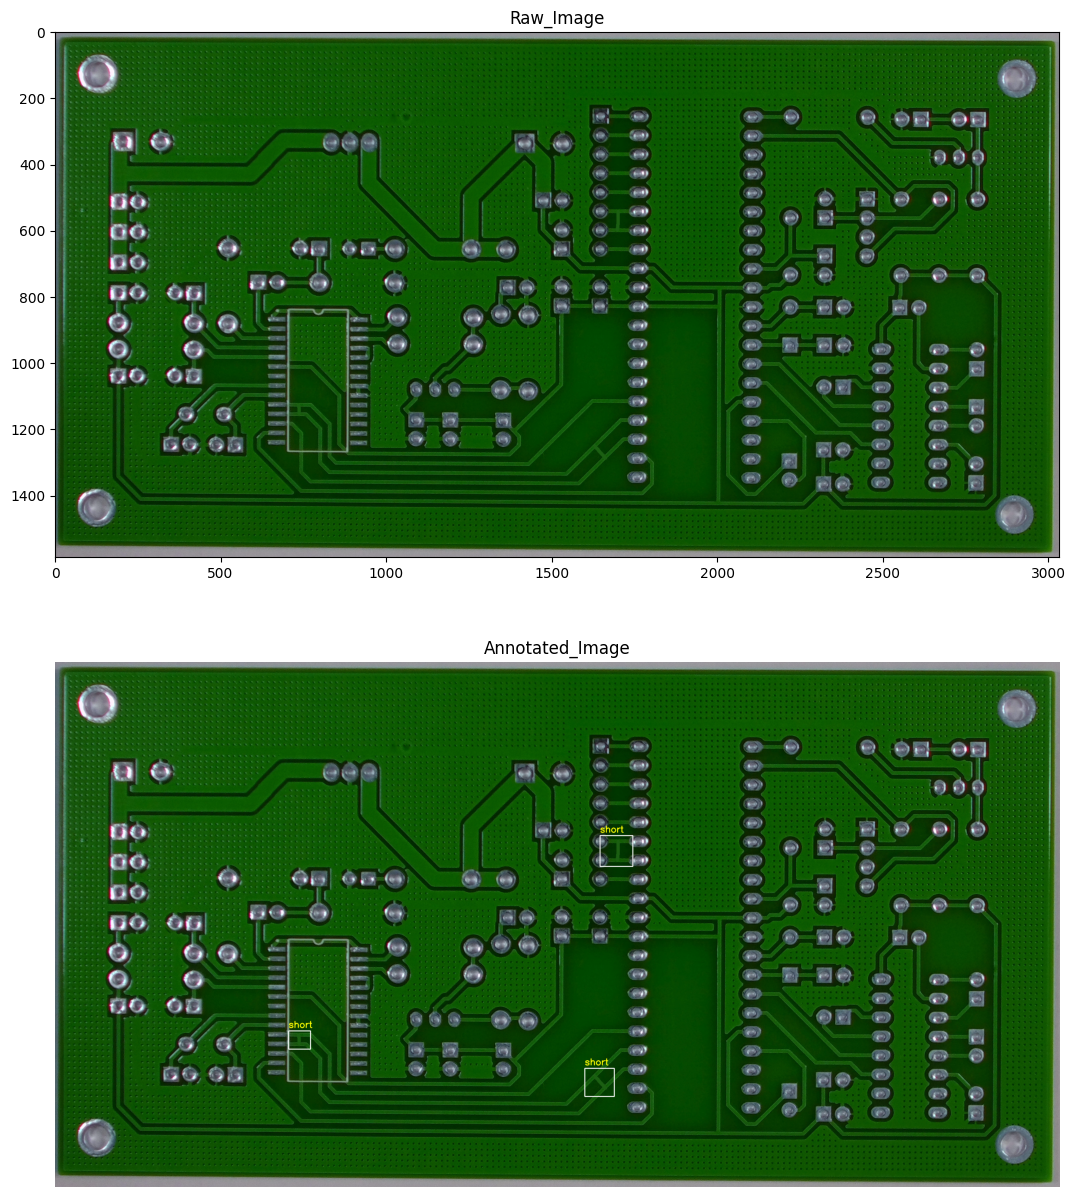

In [32]:
def visualize(image_name):
  sub_folder = get_folder(image_name)
  image_path = os.path.join(images_dir, sub_folder, image_name)

  raw_image = cv2.imread(image_path)
  image = raw_image.copy()

  annotations = data_frame[data_frame[f'file_name'] == image_name]

  for _, row in annotations.iterrows():
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']

    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 255), 2)

    cv2.putText(image, row['name'], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)


  fig, ax = plt.subplots(2,1,figsize=(15, 15))
  ax[0].imshow(raw_image)
  ax[0].set_title('Raw_Image')
  ax[1].imshow(image)
  ax[1].set_title('Annotated_Image')
  plt.axis('off')
  plt.show()

visualize('01_short_07.jpg')

# Data preprocessing

In [33]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
  os.makedirs(output_dir, exist_ok=True)

  for root, _, files in os.walk(input_dir):
    for file in files:
      if file.lower().endswith(('.jpg')):
        input_path = os.path.join(root, file)

        image = cv2.imread(input_path)

        resized_image = cv2.resize(image, target_size)

        output_path = os.path.join(output_dir, file)
        cv2.imwrite(output_path, resized_image)

resized_image_dir = '/kaggle/working/resized_images'
resize_images(images_dir, resized_image_dir)

In [34]:
def resize_annotations(annot_df, target_size=(640, 640)):
  all_data = []

  for _, row in annot_df.iterrows():

    width_ratio = target_size[0] / row['width']
    height_ratio = target_size[1] / row['height']

    resized_xmin = int(row['xmin'] * width_ratio)
    resized_ymin = int(row['ymin'] * height_ratio)
    resized_xmax = int(row['xmax'] * width_ratio)
    resized_ymax = int(row['ymax'] * height_ratio)

    all_data.append({
        'file_name': row['file_name'],
        'width': target_size[0],
        'height': target_size[1],
        'class': row['name'],
        'xmin': resized_xmin,
        'ymin': resized_ymin,
        'xmax': resized_xmax,
        'ymax': resized_ymax
    })

  annot_df_resized = pd.DataFrame(all_data)

  return annot_df_resized

In [35]:
data_frame_resized = resize_annotations(data_frame)
data_frame_resized.head()

,file_name,width,height,class,xmin,ymin,xmax,ymax
0,01_mouse_bite_11.jpg,640,640,mouse_bite,252,389,260,405
1,01_mouse_bite_11.jpg,640,640,mouse_bite,430,304,437,317
2,01_mouse_bite_11.jpg,640,640,mouse_bite,310,244,317,257
3,01_mouse_bite_17.jpg,640,640,mouse_bite,457,344,464,357
4,01_mouse_bite_17.jpg,640,640,mouse_bite,319,370,325,386


# Making YOLO labels

In [37]:
# create the ouput directory
output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

In [38]:
# Covert annotation Dataframes into YOLO labels for training
# YOLO_v8 format: <class_index> <x_center> <y_center> <width> <height>

def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
  yolo_labels = []

  for _, row in annotation_df.iterrows():
    filename = row['file_name']
    width, height = row['width'], row['height']
    class_name = row['class']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Convert bounding box coordinates to YOLO format
    x_center = (xmin + xmax) / (2 * width)
    y_center = (ymin + ymax) / (2 * height)
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    class_index = classes.index(class_name)

    # Append to YOLO labels list
    yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

  return yolo_labels

In [39]:
classes = ['missing_hole', 'mouse_bite', 'open_circuit','short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(data_frame_resized, classes)

In [40]:
print(yolo_labels[10])
print(type(yolo_labels[10]))

('08_mouse_bite_08.jpg', 1, 0.56171875, 0.284375, 0.0234375, 0.021875)
<class 'tuple'>


# Splitting dataset for training

In [41]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)



    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]


    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'w') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_image_dir, yolo_labels, output_dir)

In [42]:
dataset_yaml = os.path.join(output_dir, 'dataset.yaml')

classes = ['missing_hole', 'mouse_bite', 'open_circuit','short', 'spur', 'spurious_copper']

data_yaml = {
    'path': output_dir,
    'train': 'images/train',
    'val': 'images/val',
    'names': {i: name for i, name in enumerate(classes)}
}

with open(dataset_yaml, 'w') as f:
  yaml.dump(data_yaml, f)

print(f"YAML file created at: {dataset_yaml}")

YAML file created at: /kaggle/working/output/dataset.yaml


In [43]:
model = YOLO('yolov8s.pt')

model.train(
    data = dataset_yaml,
    epochs = 180,
    batch = 16,
    imgsz = 640,
    name = 'pcb_yolov8',
    project = 'pcb_defect_traning',
    lr0 = 0.001,
    lrf = 0.0001,
    save_period = 1,
    verbose = True,
    mixup = 0.3
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 188MB/s]


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/output/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=180, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 77.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2019.8±1235.3 MB/s, size: 160.0 KB)


train: Scanning /kaggle/working/output/labels/train... 658 images, 0 backgrounds, 0 corrupt: 100%|██████████| 658/658 [00:00<00:00, 1420.51it/s]

train: New cache created: /kaggle/working/output/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1597.9±1303.2 MB/s, size: 165.9 KB)


val: Scanning /kaggle/working/output/labels/val... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 1357.90it/s]

val: New cache created: /kaggle/working/output/labels/val.cache


Plotting labels to pcb_defect_traning/pcb_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb_defect_traning/pcb_yolov8
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      3.76G      3.661      15.25      1.817         14        640: 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         34        146   0.000848      0.121   0.000905   0.000462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      4.57G      2.973      3.933       1.29         16        640: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

                   all         34        146      0.286      0.315      0.229     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.59G      2.564      2.882      1.169          9        640: 100%|██████████| 42/42 [00:10<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         34        146      0.383       0.35      0.296      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      4.64G      2.496      2.513      1.147         15        640: 100%|██████████| 42/42 [00:10<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         34        146      0.641      0.557      0.598      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      4.66G      2.328      2.171      1.108          6        640: 100%|██████████| 42/42 [00:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         34        146      0.716      0.629      0.651      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.71G      2.304      2.083      1.093         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         34        146      0.785       0.68      0.767      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.74G      2.265      1.899      1.087         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         34        146       0.78      0.777      0.806      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.78G      2.248      1.864      1.078         24        640: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         34        146      0.814      0.683      0.778      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      4.81G      2.203      1.821      1.067         15        640: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         34        146      0.898      0.753       0.85      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.86G      2.148      1.703      1.055         13        640: 100%|██████████| 42/42 [00:10<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         34        146      0.911      0.762      0.856      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      4.88G      2.105      1.649      1.037         10        640: 100%|██████████| 42/42 [00:10<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

                   all         34        146      0.875       0.86      0.896      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.93G      2.114      1.595      1.043         19        640: 100%|██████████| 42/42 [00:11<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         34        146      0.947      0.826      0.881      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.96G      2.088      1.558      1.041         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         34        146      0.894      0.796      0.852      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180         5G      2.091      1.558      1.035         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34        146      0.799      0.829      0.848      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      5.03G      2.055      1.514      1.012          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         34        146      0.909      0.801      0.866      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      5.08G      2.023      1.502      1.019         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        146      0.815      0.773      0.805      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180       5.1G      2.035      1.501      1.021         24        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

                   all         34        146      0.917      0.865      0.892      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      5.15G      2.031      1.476      1.033         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         34        146      0.926      0.888      0.909      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      5.17G      2.046      1.456      1.021         29        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         34        146      0.933      0.879      0.894      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180      5.22G      2.018      1.435      1.014         19        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         34        146      0.939      0.875      0.924       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      5.24G       1.95        1.4      1.003          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         34        146      0.951      0.886      0.924      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180       5.3G      1.998      1.413      1.017         17        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         34        146      0.913       0.88      0.888      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      5.32G      2.007      1.398      1.004         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34        146      0.915      0.883      0.916      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      5.37G      1.984      1.388       1.01         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         34        146       0.93      0.924      0.931      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      5.39G      1.958      1.393     0.9938         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         34        146      0.928      0.894      0.908      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      5.44G      1.943      1.292      0.996         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         34        146      0.897      0.866       0.91       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      5.46G      1.945      1.347      0.998         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         34        146      0.929      0.894      0.933      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      5.51G      1.925      1.306     0.9875         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        146      0.902      0.901      0.911      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      5.54G      1.933      1.337     0.9883         22        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         34        146      0.914      0.912       0.93      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      5.58G      1.867      1.259     0.9803         24        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         34        146      0.958      0.881      0.927      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      5.93G      1.889      1.266     0.9861          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34        146      0.918       0.92      0.931      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      5.98G      1.912      1.311     0.9854          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         34        146      0.931      0.912      0.946      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180         6G      1.902      1.234     0.9766         16        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         34        146      0.903      0.899      0.916      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      6.05G      1.912       1.35     0.9834          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         34        146      0.944       0.88      0.911      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      6.08G      1.879       1.25      0.974         17        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         34        146      0.906      0.906      0.904      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      6.12G       1.86      1.272     0.9773          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34        146      0.907      0.898      0.918      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      6.15G      1.811      1.192     0.9623          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         34        146      0.946      0.886      0.938      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180       6.2G      1.836      1.177     0.9738          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         34        146      0.931      0.901      0.916      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      6.22G      1.829      1.201     0.9749          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         34        146      0.954      0.882      0.911      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      6.27G      1.848      1.185     0.9619          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         34        146      0.925        0.9      0.913      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      6.29G      1.819      1.143     0.9754         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         34        146      0.938      0.916      0.922      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      6.35G      1.878      1.223      0.978         22        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34        146      0.939      0.907      0.919      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      6.37G      1.872      1.213     0.9777         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        146      0.942      0.917      0.932       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      6.42G      1.789      1.129     0.9691         17        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         34        146      0.933      0.899      0.913      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      6.44G       1.81      1.118      0.957         23        640: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         34        146       0.95      0.895      0.917      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      6.49G      1.788      1.134     0.9565         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34        146      0.948      0.911      0.941      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      6.51G      1.793       1.15     0.9666         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         34        146      0.944      0.908      0.926       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      6.56G      1.822      1.201     0.9659         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         34        146      0.952      0.917      0.937       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      6.58G      1.799      1.149     0.9559          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         34        146       0.95      0.924      0.933      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      6.63G      1.766      1.097     0.9492         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        146      0.941      0.909      0.925      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      6.71G      1.764      1.111     0.9553          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         34        146      0.938      0.889      0.928       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      6.76G      1.782      1.128     0.9529         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         34        146      0.921      0.912      0.942      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      6.85G      1.787      1.134     0.9595         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         34        146      0.946      0.924      0.939      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180       6.9G      1.784      1.145     0.9644         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         34        146      0.941      0.927       0.92      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      6.92G      1.765      1.107     0.9396         29        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

                   all         34        146      0.952      0.926      0.936      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      7.07G      1.758      1.114     0.9545         19        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         34        146       0.92       0.89      0.909      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.03G      1.746      1.118     0.9606         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         34        146      0.931      0.924      0.935      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      4.25G      1.761      1.092     0.9596          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         34        146      0.966      0.909      0.944      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      4.57G      1.749      1.088     0.9496         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         34        146      0.956      0.915      0.949      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      4.57G      1.763      1.109     0.9557         16        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         34        146      0.959      0.912      0.942      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      4.57G      1.724      1.082      0.952         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         34        146      0.918      0.921      0.929      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      4.57G      1.733      1.082     0.9554         26        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         34        146      0.947      0.911       0.94      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      4.57G      1.773       1.11     0.9517         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         34        146      0.943      0.907      0.931      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.57G      1.719       1.07     0.9402         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         34        146      0.943      0.908      0.933      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      4.57G      1.709       1.05     0.9389         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

                   all         34        146      0.959      0.904      0.944      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      4.61G      1.723      1.076      0.946         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         34        146      0.965        0.9      0.949      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      4.63G      1.724      1.052     0.9447         28        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

                   all         34        146      0.937      0.932       0.94      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      4.68G      1.689      1.017     0.9446          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         34        146      0.941      0.914      0.937      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.71G      1.755      1.104     0.9515         24        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         34        146      0.959      0.921      0.937      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      4.75G      1.743       1.07      0.947         18        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         34        146      0.939      0.932      0.932      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      4.77G      1.702      1.041     0.9394          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         34        146      0.921      0.927      0.934       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.82G      1.697      1.057     0.9444         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         34        146      0.962      0.911       0.95      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.85G       1.67       1.01     0.9371          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

                   all         34        146      0.932      0.934      0.929      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.89G      1.692      1.029     0.9354          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         34        146      0.949      0.917      0.932      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      4.92G      1.699      1.021     0.9415         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         34        146      0.965      0.912       0.96      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.97G      1.696      1.021     0.9353         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         34        146      0.919      0.925      0.919      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      4.99G      1.693      1.037     0.9328          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         34        146      0.926      0.909      0.934      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      5.04G      1.663     0.9996     0.9279         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

                   all         34        146      0.918      0.925      0.918      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      5.07G      1.658      0.976     0.9224         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         34        146      0.915      0.892      0.919      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      5.12G      1.679      1.019     0.9363         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         34        146      0.946      0.923      0.935       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      5.14G      1.673     0.9919     0.9307         26        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         34        146      0.923      0.905       0.92      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      5.19G      1.688      1.009     0.9266         21        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         34        146      0.919      0.902      0.914       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      5.21G      1.661      1.014     0.9299         22        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         34        146      0.932      0.916      0.917       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      5.26G      1.663     0.9929     0.9284          2        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

                   all         34        146      0.934      0.905      0.924      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      5.28G      1.657      1.008     0.9272         21        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        146      0.947      0.921      0.929      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180      5.39G      1.646     0.9837     0.9326         24        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         34        146      0.944      0.937      0.934      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      5.42G      1.625     0.9539     0.9162         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

                   all         34        146      0.939      0.893      0.918      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      5.47G      1.663     0.9984     0.9251         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         34        146      0.904      0.924      0.932      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      5.49G      1.634     0.9867     0.9202         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         34        146      0.951      0.935      0.958      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      5.59G      1.645     0.9875     0.9311         17        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         34        146      0.922      0.898      0.909      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      5.67G      1.633     0.9756     0.9306          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34        146      0.955      0.912      0.948      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      5.72G      1.631     0.9666     0.9255         19        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         34        146      0.949      0.916      0.952      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180       5.8G      1.603     0.9337      0.921         16        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34        146       0.94      0.917      0.918      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      5.85G      1.626     0.9796     0.9158         19        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         34        146       0.93      0.919       0.92      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      5.93G       1.62      1.002     0.9221         25        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         34        146      0.951      0.909      0.931      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      5.98G      1.619     0.9696     0.9261         18        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         34        146      0.944      0.928      0.948      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      6.01G      1.619     0.9886     0.9182         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         34        146      0.939      0.942      0.935      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      6.14G      1.584     0.9365     0.9089         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         34        146      0.938      0.918      0.939      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      6.17G        1.6     0.9489     0.9196         27        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         34        146      0.928      0.904       0.91      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      6.28G      1.623      1.004     0.9247         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         34        146      0.932      0.909      0.926      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      6.63G      1.618     0.9646     0.9185         18        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        146      0.909      0.918      0.921      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      6.67G       1.61     0.9421     0.9202         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         34        146      0.928       0.91      0.912      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180       6.7G      1.571     0.9411     0.9131         16        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         34        146      0.932      0.929      0.931      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      6.75G      1.556     0.9254     0.9187         16        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         34        146      0.941      0.902      0.928      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180      6.77G      1.607     0.9514     0.9198          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         34        146      0.925      0.927      0.928        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180      6.82G      1.602     0.9804     0.9223         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         34        146      0.914      0.918      0.937      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180      6.84G      1.572     0.9309     0.9192         26        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         34        146       0.94      0.928      0.939      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      6.89G      1.556     0.9078     0.9134         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         34        146      0.913       0.92      0.933      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      6.92G      1.589     0.9405     0.9085          4        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         34        146      0.946       0.92      0.943      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      6.97G      1.601      0.964     0.9275         18        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         34        146      0.935      0.912      0.936      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      6.99G      1.563     0.9154     0.9129         35        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         34        146      0.935      0.924      0.942      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      7.04G      1.552     0.9297     0.8933          0        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

                   all         34        146      0.945      0.914      0.943      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      7.06G      1.556     0.9095     0.9184         11        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

                   all         34        146       0.95      0.896      0.934      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      7.11G      1.529     0.9047     0.9073          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         34        146       0.96      0.938      0.951      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      7.19G      1.545     0.8861     0.9133         32        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         34        146      0.956      0.934      0.952      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180      7.29G      1.525     0.8919     0.9177         12        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         34        146      0.957      0.922      0.956      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      7.37G      1.558     0.9204     0.9126         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         34        146      0.955      0.925      0.955      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180      7.42G      1.515     0.8943     0.9085         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         34        146      0.936      0.919      0.924      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      3.95G      1.546     0.9049     0.9151          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         34        146       0.94       0.91      0.943      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180      3.95G      1.552     0.9077     0.9051         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         34        146      0.948       0.91      0.942      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180      3.95G      1.525      0.881     0.9036         22        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         34        146      0.951      0.911      0.951        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      3.95G      1.493     0.8783     0.9061          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         34        146      0.927      0.919      0.936      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180      3.95G      1.532     0.8915     0.9049          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         34        146      0.962      0.941      0.953        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      3.95G      1.488     0.8618     0.8966          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         34        146       0.96      0.921      0.946      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      3.95G       1.52     0.9002     0.9144         31        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         34        146      0.926       0.93      0.942      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      4.01G      1.498     0.8745     0.9038         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         34        146      0.944      0.907      0.942      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      4.01G      1.518     0.9074     0.9056          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34        146      0.946      0.905      0.932      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      4.05G      1.476     0.8623     0.8985         25        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         34        146      0.937      0.934      0.945        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      4.13G      1.515     0.8969     0.9021         29        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         34        146      0.955      0.927      0.955      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      4.24G       1.45       0.84     0.8968          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         34        146      0.944      0.934      0.953      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      4.26G      1.469     0.8698     0.9011         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

                   all         34        146      0.954      0.911      0.947       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180      4.37G      1.502     0.8715     0.9013         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34        146      0.921      0.904      0.928      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180      4.39G      1.478     0.8485     0.9076          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         34        146      0.943      0.896       0.93      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      4.48G      1.483     0.8819     0.9029         43        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34        146      0.913       0.91      0.926      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      4.51G      1.482      0.845     0.8963         19        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

                   all         34        146      0.907       0.92      0.933      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180       4.6G      1.462     0.8644     0.8971          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        146      0.922      0.901      0.916      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      4.68G      1.455     0.8276     0.8949         17        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         34        146      0.928      0.918      0.931      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      4.72G      1.472     0.8778     0.9058         38        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

                   all         34        146      0.935      0.933      0.948      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180       4.8G      1.442     0.8473      0.908          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         34        146      0.934      0.923      0.929        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180       4.9G      1.489     0.8794     0.9005         28        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         34        146      0.935      0.917      0.932      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180      4.93G      1.451     0.8673     0.8913         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         34        146      0.937      0.922      0.935      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180      4.98G      1.436     0.8324     0.8892          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         34        146      0.939      0.922      0.934      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      5.06G      1.445     0.8494     0.8966         17        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         34        146      0.926      0.913      0.918      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180      5.15G      1.442     0.8333     0.8888         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         34        146      0.942       0.92      0.942      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180      5.18G      1.452     0.8595     0.8979         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         34        146      0.942      0.915      0.938      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180      5.27G      1.432     0.8489     0.8902         25        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         34        146      0.939      0.906      0.938        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180      5.29G      1.436     0.8336     0.8921         18        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         34        146      0.934      0.914      0.927      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180      5.44G      1.438     0.8521     0.8931         18        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         34        146      0.934      0.912      0.925      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      5.46G      1.416     0.8491     0.8947         20        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         34        146      0.944      0.935      0.936      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      5.56G      1.407     0.8272     0.8878          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         34        146      0.947      0.922      0.943      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      5.58G      1.406     0.8154      0.891          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         34        146      0.944       0.92      0.938      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      5.68G      1.433     0.8521     0.9023          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         34        146      0.937      0.919      0.938      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      5.71G      1.414     0.8292     0.8908          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         34        146      0.936      0.901      0.938      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180      5.81G      1.424     0.8285     0.8917         13        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         34        146      0.946      0.905      0.943      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      5.89G      1.408     0.8185     0.8814         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34        146      0.953      0.909      0.941      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180      5.94G      1.386     0.7992     0.8879         25        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         34        146      0.951      0.921      0.939      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      5.96G      1.424     0.8452     0.8956         26        640: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         34        146      0.942      0.924       0.94        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      6.06G      1.395     0.8148     0.8914         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         34        146      0.941      0.936      0.945      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      6.14G      1.373     0.7942     0.8839          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34        146      0.947      0.936      0.945      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180      6.19G      1.413     0.8387     0.8892         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         34        146      0.936       0.94      0.944      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      6.22G      1.391     0.7963     0.8849         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         34        146      0.933      0.927      0.934        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180       6.3G       1.39     0.8143     0.8974          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         34        146       0.94      0.939      0.943      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      6.38G      1.363     0.7915     0.8786         21        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         34        146      0.948      0.933      0.945      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180      6.42G      1.363     0.7897     0.8835          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         34        146      0.931      0.925      0.943      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      6.49G      1.396     0.7986     0.8933          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         34        146      0.933      0.927      0.942      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      6.59G      1.376     0.7965     0.8827          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         34        146       0.94      0.927       0.94      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      6.68G      1.361     0.7835     0.8805          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34        146      0.947      0.935      0.946      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180      6.73G      1.378     0.8095     0.8852         14        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         34        146      0.944      0.936      0.948      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      6.75G       1.37     0.8084      0.885         15        640: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

                   all         34        146      0.951      0.921      0.949      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      6.85G       1.36     0.8056     0.8825         17        640: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         34        146       0.95      0.918      0.947      0.509


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180      6.87G      1.109     0.5319     0.8573         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

                   all         34        146       0.95      0.912      0.932      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180      6.92G      1.169     0.5676     0.8612          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         34        146      0.948      0.909      0.937      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180      6.97G      1.126     0.5335     0.8566          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34        146      0.948      0.911      0.937      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180      7.06G       1.11     0.5265     0.8527         10        640: 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         34        146      0.948      0.912      0.936      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180      7.11G        1.1     0.5264     0.8548          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         34        146      0.947      0.912      0.929      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180       7.2G        1.1     0.5262     0.8574          7        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         34        146      0.948      0.911       0.93      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180      7.25G      1.106     0.5283     0.8577          6        640: 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         34        146      0.946      0.911       0.93        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180      7.33G      1.089     0.5111     0.8548          5        640: 100%|██████████| 42/42 [00:11<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         34        146      0.944      0.911       0.93      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180      7.36G      1.085      0.514     0.8552          8        640: 100%|██████████| 42/42 [00:11<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         34        146      0.944      0.911      0.931      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180      7.44G      1.098      0.528     0.8549          9        640: 100%|██████████| 42/42 [00:11<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         34        146      0.945      0.912      0.932      0.494



180 epochs completed in 0.616 hours.
Optimizer stripped from pcb_defect_traning/pcb_yolov8/weights/last.pt, 22.5MB
Optimizer stripped from pcb_defect_traning/pcb_yolov8/weights/best.pt, 22.5MB

Validating pcb_defect_traning/pcb_yolov8/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         34        146      0.957      0.923      0.956       0.52
          missing_hole          8         35      0.962          1      0.992      0.645
            mouse_bite          5         21      0.933      0.905      0.933      0.427
          open_circuit          4         18          1      0.901      0.995      0.484
                 short          6         25      0.947       0.96      0.955      0.549
                  spur          6         22      0.976      0.773      0.882      0.443
       spurious_copper          5         25      0.926      0.997      0.981      0.572
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to pcb_defect_traning/pcb_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7883a75828d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [46]:
# Load the trained model

model = YOLO('/kaggle/working/pcb_defect_traning/pcb_yolov8/weights/best.pt')

# Run evaluation on validation set
metrics = model.val()
print(metrics)


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3045.8±519.5 MB/s, size: 165.0 KB)


val: Scanning /kaggle/working/output/labels/val.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         34        146      0.957      0.923      0.956      0.524
          missing_hole          8         35      0.962          1      0.992      0.643
            mouse_bite          5         21      0.933      0.905      0.932      0.434
          open_circuit          4         18          1      0.901      0.995      0.507
                 short          6         25      0.947       0.96      0.955      0.556
                  spur          6         22      0.976      0.773      0.882      0.447
       spurious_copper          5         25      0.926      0.997      0.981      0.561
Speed: 6.2ms preprocess, 15.7ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7883a7d24910>
curves: ['Precision-Recal